In [2]:
# Hill cipher evaluation block (both modes + CDCI)
import random, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
# from caas_jupyter_tools import display_dataframe_to_user

In [3]:
random.seed(42)
np.random.seed(42)

ALPHABET = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

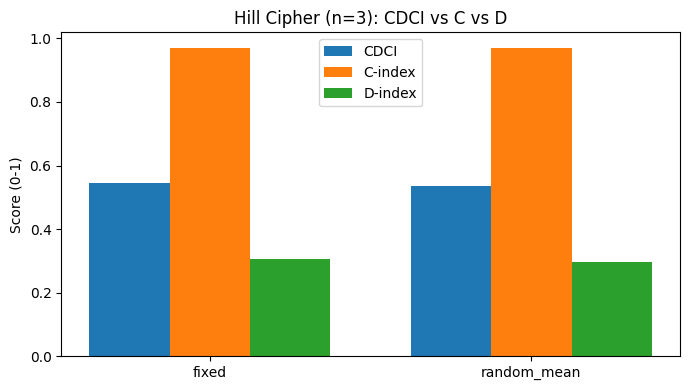

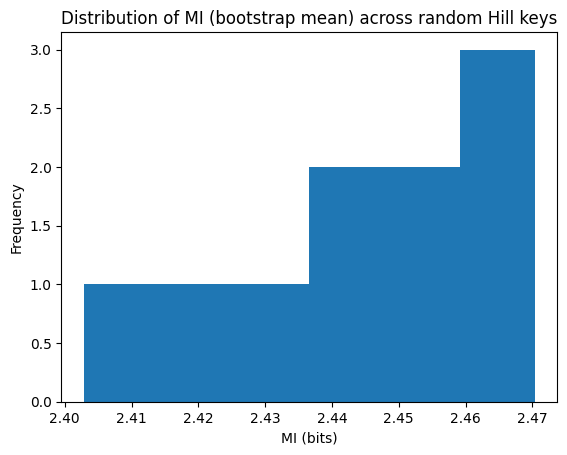

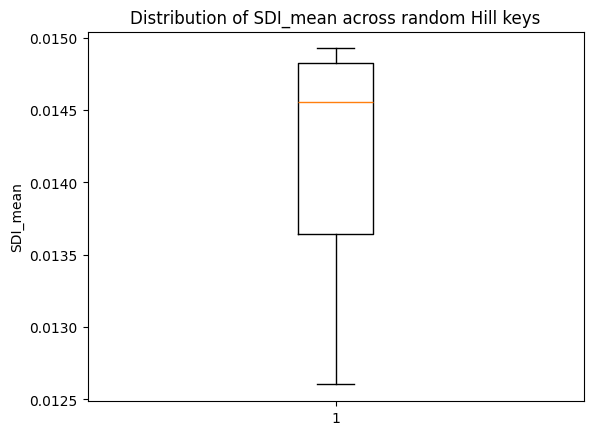

Saved: ./data/hill_cipher_fixed.csv, hill_cipher_random.csv, hill_cipher_summary.csv


In [7]:
# ---------------- HillCipher class (user-provided, re-included) ----------------
import numpy as np
from sympy import Matrix

class HillCipher:
    def __init__(self, key, n):
        self.alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.char_to_num = {char: i for i, char in enumerate(self.alphabet)}
        self.num_to_char = {i: char for i, char in enumerate(self.alphabet)}
        self.n = n
        self.key_matrix = self.getKeyMatrix(key, n)
        self.inverse_key_matrix = self.modMatInv(self.key_matrix, 26)

    def getKeyMatrix(self, key, n):
        k = 0
        keyMatrix = [[0] * n for _ in range(n)]
        for i in range(n):
            for j in range(n):
                keyMatrix[i][j] = ord(key[k]) % 65
                k += 1
        return np.array(keyMatrix)

    def padding(self, plaintext):
        plaintext = plaintext.replace(" ", "").upper()
        pad_len = (self.n - len(plaintext) % self.n) % self.n
        plaintext += 'X' * pad_len
        return plaintext, pad_len

    def encrypt(self, plaintext):
        plaintext, pad_len = self.padding(plaintext)
        blocks = np.array([[self.char_to_num[char]] for char in plaintext])
        plaintext_blocks = [blocks[i:i+self.n] for i in range(0, len(blocks), self.n)]
        ciphertext = ""
        for block in plaintext_blocks:
            encrypted_block = np.dot(self.key_matrix, block) % 26
            for num in encrypted_block:
                ciphertext += self.num_to_char[num[0]]
        return ciphertext, pad_len

    def modMatInv(self, matrix, modulus):
        M = Matrix(matrix)
        det = int(M.det()) % modulus
        if np.gcd(det, modulus) != 1:
            raise ValueError("Key matrix not invertible modulo {}".format(modulus))
        det_inv = pow(det, -1, modulus)
        adjugate = M.adjugate()
        return np.array((det_inv * adjugate) % modulus).astype(int)

    def decrypt(self, ciphertext, pad_len=0):
        blocks = np.array([[self.char_to_num[char]] for char in ciphertext])
        cipher_blocks = [blocks[i:i+self.n] for i in range(0, len(blocks), self.n)]
        decrypted_text = ""
        for block in cipher_blocks:
            decrypted_block = np.dot(self.inverse_key_matrix, block) % 26
            for num in decrypted_block:
                decrypted_text += self.num_to_char[num[0]]
        if pad_len > 0:
            decrypted_text = decrypted_text[:-pad_len]
        return decrypted_text

    def getCiphertext(self, plaintext):
        ciphertext, pad_len = self.encrypt(plaintext)
        return ciphertext, pad_len

# ---------------- helper: generate valid Hill keys (invertible matrices) -------------
def random_hill_key(n=3):
    # produce a random key string of length n*n whose matrix is invertible mod 26
    # tries repeatedly until success
    attempts = 0
    while True:
        attempts += 1
        chars = [random.choice(ALPHABET) for _ in range(n*n)]
        key_str = "".join(chars)
        try:
            _ = HillCipher(key_str, n)  # will raise ValueError if not invertible
            return key_str
        except Exception:
            if attempts > 5000:
                raise RuntimeError("Failed to generate invertible Hill key after many attempts")

def perturb_hill_key(key_str, n=3, max_trials=200):
    # try small perturbation (change one char) and accept first invertible variant
    base = list(key_str)
    for _ in range(max_trials):
        k = base[:]
        pos = random.randrange(len(k))
        k[pos] = random.choice([c for c in ALPHABET if c != k[pos]])
        cand = "".join(k)
        try:
            _ = HillCipher(cand, n)
            return cand
        except Exception:
            continue
    # fallback: swap two positions
    for _ in range(max_trials):
        k = base[:]
        i,j = random.sample(range(len(k)),2)
        k[i],k[j] = k[j],k[i]
        cand = "".join(k)
        try:
            _ = HillCipher(cand, n)
            return cand
        except Exception:
            continue
    raise RuntimeError("Could not find invertible perturbed key")

# ---------------- metric functions (same style as other blocks) ----------------
def fraction_changed(a, b):
    L = min(len(a), len(b))
    if L == 0:
        return 0.0
    return sum(x!=y for x,y in zip(a[:L], b[:L])) / L

def symbol_diffusion_index(cipher_wrapper, plaintext, key, alphabet, trials=10, n=3):
    # cipher_wrapper: function(plaintext, key_str) -> ciphertext
    C, _ = cipher_wrapper(plaintext, key)
    results = []
    L = len(plaintext.replace(" ", "").upper())
    if L == 0:
        return 0.0, 0.0
    for _ in range(trials):
        i = random.randrange(L)
        plain_filtered = "".join(ch for ch in plaintext.upper() if 'A' <= ch <= 'Z')
        new_char = random.choice([c for c in alphabet if c != plain_filtered[i]])
        P2 = plain_filtered[:i] + new_char + plain_filtered[i+1:]
        C2, _ = cipher_wrapper(P2, key)
        results.append(fraction_changed(C, C2))
    return (np.mean(results) if results else 0.0), (np.std(results) if len(results)>1 else 0.0)

def compute_ksi(cipher_wrapper, plaintext, key, key_variant):
    C, _ = cipher_wrapper(plaintext, key)
    C2, _ = cipher_wrapper(plaintext, key_variant)
    return fraction_changed(C, C2)

def mutual_information(pairs):
    N = len(pairs)
    if N == 0:
        return 0.0
    joint = Counter(pairs)
    X_counts = Counter(x for x,_ in pairs)
    Y_counts = Counter(y for _,y in pairs)
    mi = 0.0
    for (x,y), n in joint.items():
        p_xy = n/N
        p_x = X_counts[x]/N
        p_y = Y_counts[y]/N
        mi += p_xy * math.log2(p_xy/(p_x*p_y))
    return mi

def compute_mi_from_plain_cipher_lists(plain_list, cipher_list):
    pairs = list(zip("".join(plain_list), "".join(cipher_list)))
    return mutual_information(pairs)

def compute_chi_entropy(ciphertexts, alphabet):
    text = "".join(ciphertexts)
    N = len(text)
    if N == 0:
        return 0.0, 0.0
    counts = Counter(text)
    expected = N/len(alphabet)
    chi2 = sum((counts[a]-expected)**2/expected for a in alphabet)
    entropy = -sum((counts[a]/N)*math.log2(counts[a]/N) for a in counts if counts[a]>0)
    return chi2, entropy

def bootstrap_mi(pairs, n_boot=200, alpha=0.05):
    estimates=[]
    N = len(pairs)
    if N == 0:
        return 0.0, (0.0,0.0)
    for _ in range(n_boot):
        sample = [pairs[random.randrange(N)] for _ in range(N)]
        mi = mutual_information(sample)
        estimates.append(mi)
    estimates.sort()
    low = estimates[int((alpha/2)*n_boot)]
    high = estimates[int((1-alpha/2)*n_boot)]
    return np.mean(estimates), (low, high)

# ---------------- CDCI ----------------
def confusion_index(cipher_wrapper, plaintext, keyspace, samples=200):
    pairs = []
    for _ in range(samples):
        k = random.choice(keyspace)
        C, _ = cipher_wrapper(plaintext, k)
        for sym in C:
            pairs.append((str(k), sym))
    mi = mutual_information(pairs)
    H_K = math.log2(len(keyspace)) if len(keyspace)>1 else 1.0
    Cidx = 1 - (mi / H_K if H_K>0 else 0)
    return max(0, min(1, Cidx))

def ciphertext_entropy_one(cipher_wrapper, plaintext, key):
    C, _ = cipher_wrapper(plaintext, key)
    chi2, Hc = compute_chi_entropy([C], ALPHABET)
    return Hc

def diffusion_index(cipher_wrapper, plaintext, key, alphabet, alpha=0.7, trials=10):
    sdi_mean, sdi_std = symbol_diffusion_index(cipher_wrapper, plaintext, key, alphabet, trials)
    Hc = ciphertext_entropy_one(cipher_wrapper, plaintext, key)
    norm_H = Hc / math.log2(len(alphabet)) if len(alphabet)>1 else 0.0
    D = alpha*sdi_mean + (1-alpha)*norm_H
    return D, sdi_mean, sdi_std, norm_H

def cdci_score(cipher_wrapper, plaintext, key, keyspace, alphabet, alpha=0.7):
    Cidx = confusion_index(cipher_wrapper, plaintext, keyspace)
    D, sdi_mean, sdi_std, norm_H = diffusion_index(cipher_wrapper, plaintext, key, alphabet, alpha=alpha)
    return math.sqrt(Cidx*D), Cidx, D, sdi_mean, sdi_std, norm_H

# ---------------- Hill cipher wrapper ----------------
def hill_encrypt_wrapper(plaintext, key_str, n=3):
    # returns ciphertext string and pad_len (we ignore pad for metrics)
    hc = HillCipher(key_str, n)
    C, pad = hc.getCiphertext(plaintext)
    return C, pad

# ---------------- Experiment configuration ----------------
num_texts = 5
length = 200
plaintexts = []
for i in range(num_texts):
    s = "".join(random.choice(ALPHABET) for _ in range(length))
    plaintexts.append(s)
plaintexts[0] = ("THEQUICKBROWNFOXJUMPSOVERTHELAZYDOG" * 6)[:length]

# fixed key (given): "GYBNQKURP" for n=3
fixed_key = "GYBNQKURP"
n = 3

# generate random keys (valid invertible)
random_key_count = 10
random_keys = [random_hill_key(n) for _ in range(random_key_count)]
# create keyspace sample for confusion index (sample of invertible keys)
keyspace_for_confusion = [random_hill_key(n) for _ in range(60)]

# ---------------- Mode A: Fixed key evaluation ----------------
fixed_results = {}
sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]; mi_boot_cis=[]

for pt in plaintexts:
    sdi_mean, sdi_std = symbol_diffusion_index(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, fixed_key, ALPHABET, trials=20, n=n)
    sdi_vals.append(sdi_mean)
    # produce a perturbed invertible key
    try:
        pert_key = perturb_hill_key(fixed_key, n=n)
    except Exception:
        pert_key = fixed_key  # fallback (rare)
    ksi_vals.append(compute_ksi(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, fixed_key, pert_key))
    Ctext, pad = hill_encrypt_wrapper(pt, fixed_key, n)
    mi_vals.append(mutual_information(list(zip(pt, Ctext[:len(pt)]))))
    chi2, Hc = compute_chi_entropy([Ctext], ALPHABET)
    chi_vals.append(chi2); entropy_vals.append(Hc)
    pairs = list(zip(pt, Ctext[:len(pt)]))
    mean_boot, ci = bootstrap_mi(pairs, n_boot=150)
    mi_boot_means.append(mean_boot); mi_boot_cis.append(ci)

fixed_results['SDI_mean'] = np.mean(sdi_vals)
fixed_results['SDI_std']  = np.mean([sdi_std for _ in range(len(sdi_vals))])  # rough
fixed_results['KSI_mean'] = np.mean(ksi_vals)
fixed_results['MI_mean']  = np.mean(mi_vals)
fixed_results['Chi2_mean'] = np.mean(chi_vals)
fixed_results['Entropy_mean'] = np.mean(entropy_vals)
fixed_results['MI_boot_mean'] = np.mean(mi_boot_means)
fixed_results['MI_boot_CI_low'] = np.mean([ci[0] for ci in mi_boot_cis])
fixed_results['MI_boot_CI_high'] = np.mean([ci[1] for ci in mi_boot_cis])

fixed_cdci, fixed_C, fixed_D, sdi_mean, sdi_std, norm_H = cdci_score(lambda p,k: hill_encrypt_wrapper(p,k,n), plaintexts[0], fixed_key, keyspace_for_confusion, ALPHABET)
fixed_results['CDCI'] = fixed_cdci
fixed_results['C_index'] = fixed_C
fixed_results['D_index'] = fixed_D

fixed_df = pd.DataFrame([fixed_results])

# ---------------- Mode B: Random keys evaluation ----------------
random_mode_results = []
for rk in random_keys:
    sdi_vals=[]; ksi_vals=[]; mi_vals=[]; chi_vals=[]; entropy_vals=[]; mi_boot_means=[]
    for pt in plaintexts:
        sdi_mean, sdi_std = symbol_diffusion_index(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, rk, ALPHABET, trials=12, n=n)
        sdi_vals.append(sdi_mean)
        # produce perturbed key variant
        try:
            pert = perturb_hill_key(rk, n=n)
        except Exception:
            pert = rk
        ksi_vals.append(compute_ksi(lambda p,k: hill_encrypt_wrapper(p,k,n), pt, rk, pert))
        Ctext, pad = hill_encrypt_wrapper(pt, rk, n)
        mi_vals.append(mutual_information(list(zip(pt, Ctext[:len(pt)]))))
        chi2, Hc = compute_chi_entropy([Ctext], ALPHABET)
        chi_vals.append(chi2); entropy_vals.append(Hc)
        pairs = list(zip(pt, Ctext[:len(pt)]))
        mean_boot, _ = bootstrap_mi(pairs, n_boot=120)
        mi_boot_means.append(mean_boot)
    CDCI, Cidx, Didx, sdi_mean, sdi_std, norm_H = cdci_score(lambda p,k: hill_encrypt_wrapper(p,k,n), plaintexts[0], rk, keyspace_for_confusion, ALPHABET)
    random_mode_results.append({
        'key': rk,
        'SDI_mean': np.mean(sdi_vals),
        'SDI_std_mean': np.mean([sdi_std]),
        'KSI_mean': np.mean(ksi_vals),
        'MI_mean': np.mean(mi_vals),
        'Chi2_mean': np.mean(chi_vals),
        'Entropy_mean': np.mean(entropy_vals),
        'MI_boot_mean': np.mean(mi_boot_means),
        'CDCI': CDCI,
        'C_index': Cidx,
        'D_index': Didx
    })

random_df = pd.DataFrame(random_mode_results)

summary = pd.DataFrame({
    'mode': ['fixed', 'random_mean'],
    'SDI_mean': [fixed_results['SDI_mean'], random_df['SDI_mean'].mean()],
    'KSI_mean': [fixed_results['KSI_mean'], random_df['KSI_mean'].mean()],
    'MI_mean': [fixed_results['MI_mean'], random_df['MI_mean'].mean()],
    'Entropy_mean': [fixed_results['Entropy_mean'], random_df['Entropy_mean'].mean()],
    'CDCI': [fixed_results['CDCI'], random_df['CDCI'].mean()],
    'C_index': [fixed_results['C_index'], random_df['C_index'].mean()],
    'D_index': [fixed_results['D_index'], random_df['D_index'].mean()],
})

# # ---------------- Outputs ----------------
# display_dataframe_to_user("Hill Cipher - Fixed Key Results", fixed_df)
# display_dataframe_to_user("Hill Cipher - Random Keys Results", random_df)
# display_dataframe_to_user("Hill Cipher - Summary", summary)

# Plots: CDCI/C/D
labels = summary['mode']; x = np.arange(len(labels)); width = 0.25
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(x-width, summary['CDCI'], width, label='CDCI')
ax.bar(x, summary['C_index'], width, label='C-index')
ax.bar(x+width, summary['D_index'], width, label='D-index')
ax.set_xticks(x); ax.set_xticklabels(labels); ax.set_ylabel('Score (0-1)')
ax.set_title('Hill Cipher (n=3): CDCI vs C vs D'); ax.legend(); plt.tight_layout(); plt.show()

plt.hist(random_df['MI_boot_mean'].dropna(), bins=6)
plt.title('Distribution of MI (bootstrap mean) across random Hill keys'); plt.xlabel('MI (bits)'); plt.ylabel('Frequency'); plt.show()

plt.boxplot(random_df['SDI_mean'].dropna())
plt.title('Distribution of SDI_mean across random Hill keys'); plt.ylabel('SDI_mean'); plt.show()

# Save CSVs
fixed_df.to_csv('./data/hill_cipher_fixed.csv', index=False)
random_df.to_csv('./data/hill_cipher_random.csv', index=False)
summary.to_csv('./data/hill_cipher_summary.csv', index=False)
print("Saved: ./data/hill_cipher_fixed.csv, hill_cipher_random.csv, hill_cipher_summary.csv")

In [8]:
fixed_df

,SDI_mean,SDI_std,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,MI_boot_CI_low,MI_boot_CI_high,CDCI,C_index,D_index
0,0.013333,0.0033,0.311443,2.036095,23.686567,4.613944,2.490595,2.34873,2.641759,0.54343,0.970601,0.304261


In [10]:
random_df

,key,SDI_mean,SDI_std_mean,KSI_mean,MI_mean,Chi2_mean,Entropy_mean,MI_boot_mean,CDCI,C_index,D_index
0,LJDBMOUPA,0.013516,2.279888e-03,0.308458,1.966139,28.446766,4.593852,2.439314,0.533941,0.967212,0.294758
1,BTMLMGYLD,0.014842,1.734723e-18,0.312438,1.959585,31.551244,4.572901,2.426647,0.531899,0.969935,0.291686
2,MZOVJMMAZ,0.013101,2.279888e-03,0.310448,2.005625,27.463682,4.600712,2.466716,0.538519,0.968815,0.299337
3,QPNXXLJAH,0.012604,1.990050e-03,0.307463,1.978383,34.655721,4.574880,2.437136,0.537594,0.970285,0.297858
4,XXEGFRFHX,0.014760,1.492537e-03,0.311443,1.962184,36.000995,4.568319,2.424942,0.534562,0.969878,0.294631
5,JYORBMPXF,0.014677,1.990050e-03,0.310448,1.948867,45.159204,4.534500,2.402853,0.526438,0.969235,0.285934
6,VZWQPIGLZ,0.014925,1.734723e-18,0.313433,2.024279,28.291542,4.594465,2.470365,0.539232,0.968668,0.300176
7,MBJRLFPJO,0.014842,1.734723e-18,0.304478,1.991636,25.756219,4.601434,2.453341,0.542500,0.968910,0.303750
8,YLWMMRPIX,0.014428,2.985075e-03,0.315423,1.999537,28.601990,4.594158,2.462699,0.541536,0.969752,0.302408
9,BXXENZOYB,0.014013,1.990050e-03,0.311443,1.997107,34.552239,4.572555,2.451033,0.535186,0.969890,0.295316


In [12]:
summary

,mode,SDI_mean,KSI_mean,MI_mean,Entropy_mean,CDCI,C_index,D_index
0,fixed,0.013333,0.311443,2.036095,4.613944,0.543430,0.970601,0.304261
1,random_mean,0.014171,0.310547,1.983334,4.580778,0.536141,0.969258,0.296585
